In [29]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

## Definición de la carga de datos

In [30]:
def cargar_datos_txt(fichero):
    path = os.path.join(os.getcwd(), fichero)
    lineas = csv.reader(open(path, newline='\n'))
    data = []
        
        
    for linea in lineas:
        fila = []
        for i in range(0, len(linea)):
            fila.append(int(linea[i]))
        data.append(fila)
        
    return data

In [31]:
def crear_matriz_recompensas(data, fin):
    
    cantidad = len(data)*len(data[0])
    
    lista = []
    for i in range(0, cantidad):
        lista.append([-1]*cantidad)
    
    #Definir vecinos
    for i in range(0, len(data)):
        
        for j in range(0, len(data[i])):
            actual = data[i][j]
            
        
            
            if len(data)  > i+1:
                vecino1 = data[i+1][j]
                if vecino1 == fin:
                    lista[actual][vecino1] = 100
                else:
                    lista[actual][vecino1] = 0
                    
            if 0 <= i-1:
                vecino2 = data[i-1][j]
                if vecino2 == fin:
                    lista[actual][vecino2] = 100
                else:
                    lista[actual][vecino2] = 0
                    
            if len(data[i]) > j+1:
                vecino3 = data[i][j+1]
                if vecino3 == fin:
                    lista[actual][vecino3] = 100
                else:
                    lista[actual][vecino3] = 0
                
            if 0 <= j-1:
                vecino4 = data[i][j-1]
                if vecino4 == fin:
                    lista[actual][vecino4] = 100
                else:
                    lista[actual][vecino4] = 0
            
    lista[fin][fin] = 100
    return lista
            
            
    

In [32]:
#Inicializa la matriz Q para el algorimo de Q-Learning, con los pesos de cada
#acción inicializados a 0
def inicializa_Q(recompensas):
   
    lista = []
    for i in range(0, len(recompensas)):
        lista.append([0]*len(recompensas))
     
    return lista 

In [33]:
def carga_matriz_recompensas(fichero):
    datos = cargar_datos_txt(fichero)
    return datos

In [34]:
def cargar_datos():
    
    tipo = int(input('''Si quieres que se genere la matriz de recompensas a partir de un tablero pulsa 0,
si quieres cargar tu matriz de recompensas pulsa 1: '''))
    
    inicio = int(input('Introduce el valor de la casilla de inicio: '))
    
    fin = int(input('Introduce el valor de la casilla objetivo: '))
    
    epochs = int(input('Introduce el número de episodios de entrenamiento: '))
    
    gamma = float(input('Introduce el valor del factor de aprendizaje gamma: '))
    
    tablero = str(input('Introduce el nombre del fichero desde el que quieres cargar los datos: '))
    
    tablero = './' + tablero + '.txt'
    
    if tipo == 0:
        
        data = cargar_datos_txt(tablero)
    
        recompensas = crear_matriz_recompensas(data, fin)
    
        q = inicializa_Q(recompensas)
        
    else:
        
        data = cargar_datos_txt(tablero)
        
        recompensas = str(input('Introduce el nombre del fichero desde el que quieres cargar la matriz de recompensas: '))
    
        recompensas = './' + recompensas + '.txt'
        
        recompensas = cargar_datos_txt(recompensas)
        
        q = inicializa_Q(recompensas)
        
    
    return data, recompensas, q, inicio, fin, epochs, gamma

## Definición de algoritmo de Q-Learning Fase 1

In [35]:
def seleccionar_accion_aleatoria(valor, recompensas):
    aleatorio = -1
    while aleatorio == -1:
        casilla = np.random.randint(len(recompensas),size=1)[0]
        aleatorio = recompensas[valor][casilla]
        
    return casilla    

In [36]:
def calcula_rendimiento(q):
    suma = 0
    maximo=1
    for i in range(0, len(q)):
        suma+=sum(q[i])
        if maximo < max(q[i]):
            maximo = max(q[i])
    return (suma/maximo)*100   

In [37]:
def muestra_rendimiento(rendimiento):
    plt.title('Rendimiento del algoritmo de Q-Learning')
    plt.xlabel('Número de episodios de entrenamiento')
    plt.ylabel('Valor del rendimiento del algoritmo')
    plt.plot(rendimiento)
    plt.show()

In [38]:
def calcular_camino(q,inicio,fin):
    posicion = inicio
    camino = []
    camino.append(inicio)
    converge = True
    representacion = ''
    
    while posicion != fin:
        
        maximo = max(q[posicion])
        siguiente = q[posicion].index(maximo)
        posicion = siguiente
    
        if(posicion in camino):
            print('El algoritmo ha entrado en bucle al buscar un camino')
            converge = False
            break

        camino.append(siguiente)
        
    for i in range(len(camino)):
        representacion += str(camino[i])+' -> '
        
    if(converge):    
        print('El camino óptimo es: ', representacion[0:-4])
        
    return camino, converge

In [39]:
def q_learning(data, recompensas, q, fin, epochs, gamma, bol_camino, inicio):
    rendimiento = []
    for epoch in range(0, epochs):
        
        print('Época = '+str(epoch), 'Completado al '+str((epoch/epochs)*100)+'%')
        i = np.random.randint(len(data) ,size=1)[0]
        j = np.random.randint(len(data[i]),size=1)[0]
        estado = data[i][j]
        primero = True
        
        while (estado != fin) or (primero):
            
            accion = seleccionar_accion_aleatoria(estado, recompensas)
            maximo = max(q[accion])
            q[estado][accion] = recompensas[estado][accion] + gamma*maximo
            estado = accion
            primero = False
            
        rendimiento.append(calcula_rendimiento(q))
        if bol_camino:
            calcular_camino(q, inicio, fin)
    print('Entrenamiento finalizado')
    return q, rendimiento

## Definición de algoritmo de Q-Learning Fase 2

In [40]:
def selecionar_accion_aleatoria_F2(estado, recompensas, q, epsilon):
    aleatorio = np.random.rand(1)[0]
    if aleatorio < epsilon:
        res = seleccionar_accion_aleatoria(estado, recompensas)
    else:
        acciones_posibles =[]
        posible=True
        acciones = recompensas[estado]#acciones que hay, validas e invalidas
        counter = 0
        #de las acciones me quedo con el indice de las validas
        for i in acciones:
            if i >= 0:
                acciones_posibles.append(counter)
            counter+=1
        maximo = max(q[estado])#miro el valor maximo de todas las acciones, que por definición tiene que ser >=0
        is_not_max = True
        #cojo una acción posible aleatoria que sea igual al maximo posible, esto es porque puede haber varios valores dentro
        #de la matriz Q que sean igual de grandes, por ejemplo al principio son todo 0, y hay que escojer uno de forma aleatoria
        while is_not_max:
            aleatorio_maximo = random.choice(acciones_posibles)
            if q[estado][aleatorio_maximo] == maximo:
                is_not_max = False

        res = aleatorio_maximo
    return res

In [41]:
def q_learning_F2(data, recompensas, q, fin, epochs, gamma, epsilon, alpha, bol_camino, inicio):
    rendimiento = []
    for epoch in range(0, epochs):
        

        print('Época = '+str(epoch), 'Completado al '+str((epoch/epochs)*100)+'%')
        i = np.random.randint(len(data) ,size=1)[0]
        j = np.random.randint(len(data[i]),size=1)[0]
        estado = data[i][j]
        primero = True
        epsilon_prima = epsilon
        while (estado != fin) or (primero):
            #print(epsilon,alpha)
            accion = selecionar_accion_aleatoria_F2(estado, recompensas, q, epsilon)
            maximo = max(q[accion])
            q[estado][accion] = recompensas[estado][accion] + gamma*maximo
            estado = accion
            primero = False
            epsilon_prima *= alpha

        rendimiento.append(calcula_rendimiento(q))

        
        if bol_camino:
            calcular_camino(q, inicio, fin)

    print('Entrenamiento finalizado')
    return q, rendimiento

## Creación del algoritmo SARSA

In [42]:
def sarsa(data, recompensas, q, fin, epochs, gamma, alpha, bol_camino, inicio):
    rendimiento = []
    for epoch in range(0, epochs):
        
        print('Época = '+str(epoch), 'Completado al '+str((epoch/epochs)*100)+'%')
        i = np.random.randint(len(data) ,size=1)[0]
        j = np.random.randint(len(data[i]),size=1)[0]
        estado = data[i][j]
        primero = True
        
        while (estado != fin) or (primero):
            
            accion = seleccionar_accion_aleatoria(estado, recompensas)
            estado2 = accion
            accion2 = seleccionar_accion_aleatoria(accion, recompensas)
            q[estado][accion] = q[estado][accion] +alpha*(recompensas[estado][accion] + gamma*q[estado2][accion2] - q[estado][accion])
            estado = accion
            primero = False
            
        rendimiento.append(calcula_rendimiento(q))
        if bol_camino:
            calcular_camino(q, inicio, fin)
    print('Entrenamiento finalizado')
    return q, rendimiento


## Creación de representación en forma de Grafo

In [43]:
def crea_vertices(recompensas):
    vertices = []
    
    for i in range(0,len(recompensas)):
        vertices.append(i)
        
    return vertices

In [44]:
def crea_aristas(recompensas):
    aristas = []
    
    for i in range(0,len(recompensas)):
        for j in range(0,len(recompensas)):
            if recompensas[i][j]>=0:
                aristas.append([i,j])
                
    return aristas

In [45]:
def crea_colores(camino, recompensas, inicio, fin):
    color_map = []
    for i in range(0, len(recompensas)):
        if i in camino:
            if i == inicio or i == fin:
                color_map.append('yellow')
            else:
                color_map.append('red')
        else:
            color_map.append('cyan')
    return color_map

In [46]:
def muestra_grafo_camino(q,recompensas,inicio,fin):
    
    camino, converge = calcular_camino(q, inicio, fin)
    if converge:
        grafo = nx.Graph()
        grafo.add_nodes_from(crea_vertices(recompensas))
        grafo.add_edges_from(crea_aristas(recompensas))
        color_map = crea_colores(camino, recompensas, inicio, fin)
        print('''
Leyenda:
inicio/fin = amarillo
camino escogido = rojo
resto de casillas = azul
        ''')
        plt.figure()
        nx.draw_spring(grafo, with_labels=True, font_weight='bold', node_color=color_map)
        plt.show()

## Recopilación de todo en una función

In [50]:
def ejecuta_QLearning():
    
    data, recompensas, q, inicio, fin, epochs, gamma = cargar_datos()
    
    camino_intermedio = int(input('Si quiere que se muestren los caminos intermedios pulse 1: '))
    eleccion = int(input('''¿Qué algoritmo quieres usar?
1 - Algoritmo Q_learning fase 1
2 - Algoritmo Q_learning fase 2
3 - Algoritmo SARSA: '''))
    bol_camino = camino_intermedio == 1
    
    if eleccion == 1:
        q, rendimiento  = q_learning(data, recompensas, q, fin, epochs, gamma, bol_camino, inicio)
    
    elif eleccion == 2:
        
        epsilon = float(input('Introduce el valor del parámetro epsilon: '))
        alpha = float(input('Introduce el valor del parámetro alpha: '))
        
        q, rendimiento  = q_learning_F2(data, recompensas, q, fin, epochs, gamma, epsilon, alpha, bol_camino, inicio)
    
    elif eleccion == 3:
        
        alpha = float(input('Introduce el valor del parámetro alpha: '))
        q, rendimiento = sarsa(data, recompensas, q, fin, epochs, gamma, alpha, bol_camino, inicio)
        
    print('\nMatriz Q obtenida =\n')
    for i in range(len(q)):
        print(str(i)+':',q[i])
        
    muestra_rendimiento(rendimiento)
    
    muestra_grafo_camino(q,recompensas,inicio,fin)
        
    return q, recompensas

# Main:

Si quieres que se genere la matriz de recompensas a partir de un tablero pulsa 0,
si quieres cargar tu matriz de recompensas pulsa 1: 1
Introduce el valor de la casilla de inicio: 0
Introduce el valor de la casilla objetivo: 6
Introduce el número de episodios de entrenamiento: 30
Introduce el valor del factor de aprendizaje gamma: 0.5
Introduce el nombre del fichero desde el que quieres cargar los datos: ejemplo
Introduce el nombre del fichero desde el que quieres cargar la matriz de recompensas: recompensas
Si quiere que se muestren los caminos intermedios pulse 1: 3
¿Qué algoritmo quieres usar?
1 - Algoritmo Q_learning fase 1
2 - Algoritmo Q_learning fase 2
3 - Algoritmo SARSA: 1
Época = 0 Completado al 0.0%
Época = 1 Completado al 3.3333333333333335%
Época = 2 Completado al 6.666666666666667%
Época = 3 Completado al 10.0%
Época = 4 Completado al 13.333333333333334%
Época = 5 Completado al 16.666666666666664%
Época = 6 Completado al 20.0%
Época = 7 Completado al 23.333333333333332%
É

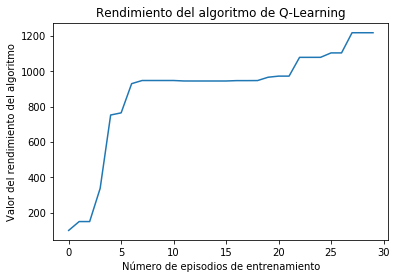

El algoritmo ha entrado en bucle al buscar un camino


In [56]:
def main(): 
    
    q, recompensas = ejecuta_QLearning()
    
if __name__ == "__main__": main()

In [23]:
'''
i = 0.1
while i<=1:
    for b in range(0,4):
        q = inicializa_Q(data)
        q, rendimiento = q_learning_F2(data, recompensas, q, 0, 6, 50, 0.5, 1, i)
        print('i = ', i)
        muestra_rendimiento(rendimiento)
    i+=0.1
'''

"\ni = 0.1\nwhile i<=1:\n    for b in range(0,4):\n        q = inicializa_Q(data)\n        q, rendimiento = q_learning_F2(data, recompensas, q, 0, 6, 50, 0.5, 1, i)\n        print('i = ', i)\n        muestra_rendimiento(rendimiento)\n    i+=0.1\n"

Época = 0 Completado al 0.0%
El algoritmo no ha logrado encontrar un camino óptimo
Época = 1 Completado al 2.0%
El algoritmo no ha logrado encontrar un camino óptimo
Época = 2 Completado al 4.0%
El algoritmo no ha logrado encontrar un camino óptimo
Época = 3 Completado al 6.0%
El algoritmo no ha logrado encontrar un camino óptimo
Época = 4 Completado al 8.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 5 Completado al 10.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 6 Completado al 12.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 7 Completado al 14.000000000000002%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 8 Completado al 16.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 9 Completado al 18.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 10 Completado al 20.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época = 11 Completado al 22.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 14
Época

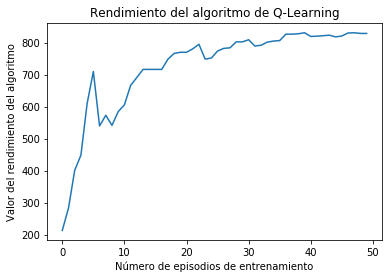

matriz Q====================
[0, 31.25, 0, 14.166259765625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 15.46875, 0, 54.21875, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 11.66666030883789, 0, 0.0, 0, 15.9375, 0, 31.71875, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 13.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0.0, 0, 0, 0, 0.0, 0, 0, 0, 89.21875, 0, 0, 0, 0, 0]
[0, 0, 8.33251953125, 0, 0, 0, 0.0, 0, 0, 0, 33.4375, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 89.21875, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 64.21875, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.0, 0, 0, 0, 51.71875, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 13.333333330228925, 0, 0, 0, 0, 0, 34.21875, 0, 0, 139.21875, 0]
[0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 69.21875, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 43.4375, 0, 0, 0, 31.875, 0, 139.21875, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 63.75, 0, 0, 198.4375]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 199.21875]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 198.4375]
matriz R====================
[-1, 10, -1, 10, -1, -1, -1, -1, -1, -

In [24]:
data = cargar_datos_txt('./ejemplo2.txt')
fin=14
recompensas = cargar_datos_txt('./recompensas2.txt')
#recompensas = crear_matriz_recompensas(data,fin)
q = inicializa_Q(recompensas)
gamma = 0.5
alpha=0.5
epsilon= 0.1
bol_camino = True
inicio = 0
epochs= 50
#q, rendimiento  = q_learning(data, recompensas, q, fin, epochs, gamma, True, inicio)
q, rendimiento  = q_learning_F2(data, recompensas, q, fin, epochs, gamma,epsilon, alpha, True, inicio)
muestra_rendimiento(rendimiento)
print('matriz Q====================')
for i in range(0,len(q)):
    print(q[i])
print('matriz R====================')
for i in range(0,len(recompensas)):
    print(recompensas[i])

Época = 0 Completado al 0.0%
El algoritmo no ha logrado encontrar un camino óptimo
Época = 1 Completado al 2.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 2 Completado al 4.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 3 Completado al 6.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 4 Completado al 8.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 5 Completado al 10.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 6 Completado al 12.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 7 Completado al 14.000000000000002%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 8 Completado al 16.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 9 Completado al 18.0%
El camino óptimo es:  0 -> 3 -> 8 -> 7 -> 6 -> 11 -> 12 -> 14
Época = 10 Completado al 20.0%
El camino óptimo es:  0 -> 1 -> 4 -> 9 -> 13 -> 

C:\Users\javie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


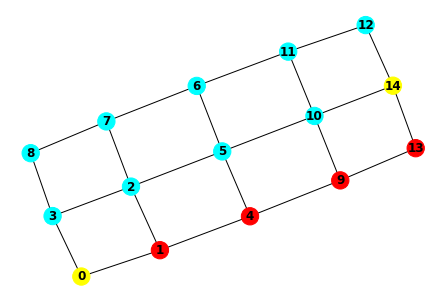

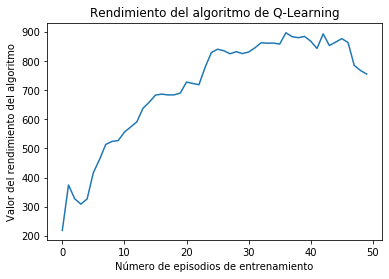

In [25]:
data = cargar_datos_txt('./ejemplo2.txt')
inicio=0
fin=14
recompensas = cargar_datos_txt('./recompensas2.txt')
q = inicializa_Q(recompensas)
alpha=0.5
gamma= 0.5
bol_camino = True
epochs= 50
q, rendimiento = sarsa(data, recompensas, q, fin, epochs, gamma, alpha, bol_camino, inicio)
muestra_grafo_camino(q,recompensas,inicio,fin)   
muestra_rendimiento(rendimiento)